In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

from text_to_vec import TextToVec
from preprocess import Preprocess
from utils.visualize import Visualize
from utils.saving import Saving
from utils.data_loader import DataLoader
from models import *

# Setup

In [3]:
data_loader = DataLoader(data_root="../../data")
saving = Saving(directory="results")
preprocess = Preprocess(data_loader)
!ls $data_loader.root

2018-Valence-oc-En-dev.txt    emoji.py
2018-Valence-oc-En-test.txt   GoogleNews-vectors-negative300.bin
2018-Valence-oc-En-train.txt  __pycache__
data_train_3.csv	      test.txt
data_train_7.csv


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/christian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/christian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def preprocessing(data, preprocess, text2vec, output_dim = None):
    texts = data["text"].values
    texts = np.vectorize(preprocess.text_standardization)(texts)
    texts = text2vec.sequence_texts(texts)
    if output_dim is not None:
        label = to_categorical(data["class"] + output_dim // 2, output_dim)
        return texts, label
    return texts, None

# Generate Text2vec and save it.
Text2vec save the Tokenizer and Embedding matrix.  
**Only run once**

In [3]:
all_data = data_loader.load_tweet_v2(data_loader.train_7_v2_path)\
    .append(data_loader.load_tweet_v2(data_loader.val_7_v2_path))\
    .append(data_loader.load_tweet(data_loader.train_3_path))\
    .append(data_loader.load_tweet(data_loader.train_7_path))

In [ ]:
vocab = all_data['text'].apply(preprocess.text_standardization)
text_processing = TextToVec()
text_processing.fit(data_loader, vocab, 300)
saving.touch_dir("save")  # Create save directory if not exist
text_processing.save("save/tp-all-300.save")

# Train model with 3 outputs

In [6]:
text2vec = TextToVec.load("save/tp-all-300.save")  # Load text2vec

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 32, 300)           13570200  
_________________________________________________________________
gru (GRU)                    (None, 32)                32064     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 13,603,419
Trainable params: 33,219
Non-trainable params: 13,570,200
_______________________________________

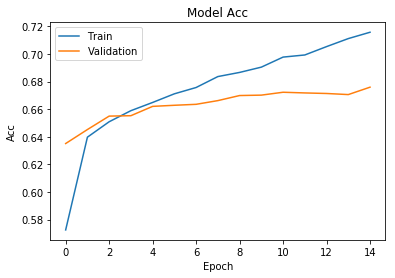

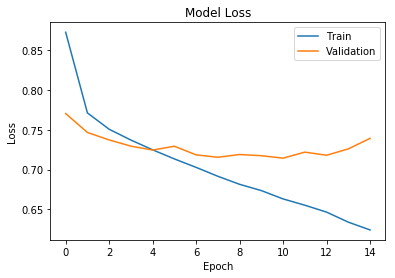

In [7]:
train_3 = data_loader.load_tweet(data_loader.train_3_path)
texts, labels = preprocessing(train_3, preprocess, text2vec, 3)
texts, labels = shuffle(texts, labels)
X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.2)

embedding_layer = text2vec.get_embedding_layer(trainable=False)

model3, model3_name = model3_gru(embedding_layer, saving)
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model3.summary()
history = model3.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=15, batch_size=100,
                    callbacks=saving.get_callbacks(model3_name, tensorboard=False, model_checkpoint=False))

Visualize.plot_history(history.history, output="/tmp")
saving.save_model(model3, model3_name, override=True)

# Train model 7

[Saving] Loading model at: results/model4/model4.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 32, 300)           13570200  
_________________________________________________________________
gru (GRU)                    (None, 32)                32064     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                2112      
_________________________________________________________________
drop

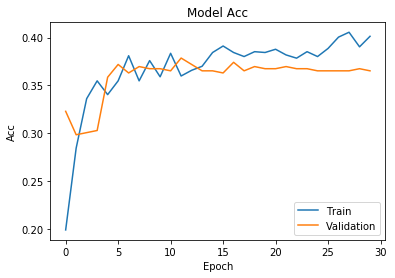

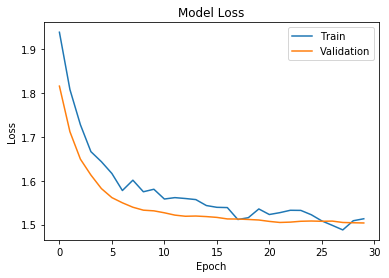

In [8]:
train_7_v2 = data_loader.load_tweet_v2(data_loader.train_7_v2_path)
val_7_v2 = data_loader.load_tweet_v2(data_loader.val_7_v2_path)

texts, labels = preprocessing(train_7_v2, preprocess, text2vec, 7)
val, vlabels = preprocessing(val_7_v2, preprocess, text2vec, 7)

embedding_layer = text2vec.get_embedding_layer(trainable=False)

_, model3_name = model3_gru(embedding_layer, saving)
model3 = saving.load_model(model3_name)

model7, model7_name = model7(model3, saving, trainable=False)
model7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model7.summary()
history = model7.fit(texts, labels, validation_data=(val, vlabels),
                    epochs=30, batch_size=100,
                    callbacks=saving.get_callbacks(model7_name, tensorboard=False, model_checkpoint=False))

Visualize.plot_history(history.history, output="/tmp")
saving.save_model(model7, model7_name, override=True)

# Predict

In [11]:
model = saving.load_model("model7")
test_data = data_loader.load_tweet_v2(data_loader.test_7_v2_path)
texts, _ = preprocessing(test_data, preprocess, text2vec)
test_data["class"] = np.argmax(model.predict(texts), axis=1)
data_loader.write_tweet_v2(test_data, "predict.csv")

[Saving] Loading model at: results/model7/model7.h5
